# Percolation on complex networks

This notebook serves at providing a brief introduction to the numerical study of percolation processes in complex networks. Given the large volume of work on this topic, the document illustrates only a small number of percolation models.


## Outline

* Naive implementations of the ordinary bond and site percolation models
* Newman-Ziff algorithm for the ordinary bond and site percolation models
* Message-passing equations for ordinary percolation models on sparse networks
* Explosive percolation
* Optimal percolation
* Ordinary site percolation on multiplex networks
* Message-passing equations for ordinary site percolation on sparse multiplex networks

### Libraries used in this notebook

In [1]:
import networkx as nx
import random
import numpy as np
import time
import sys
from scipy.stats import binom


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


from datetime import datetime
random.seed(datetime.now()) 

## Ordinary bond and site percolation models

The functions below provides naive implementations of the bond and site percolation models. Both functions have two inputs: the graph $G$ where the model is applied to, and the occupation probability $p$. In the ordinary bond percolation, edges are present with probability $p$; in the ordinary site-percolation model, nodes are present with probability $p$.  The output of the functions is a graph corresponding to a single instance of the percolation model with given inputs.

In [2]:
## This function returns an instance of the bond percolation model 
## with bond occupation probability p applied to the graph G
def ordinary_bond_percolation (G, p):

    ## create an empty graph
    H = nx.Graph()
    
    ## nodes are always present
    for n in G:
        H.add_node(n)
        
    ## edges are present with probability p
    for e in G.edges():
        if random.random() <= p:
            H.add_edge(e[0], e[1])
            
    return H


## This function returns an instance of the site percolation model 
## with site occupation probability p applied to the graph G
def ordinary_site_percolation (G, p):

    ## copy the graph
    H = G.copy()
    
    ## nodes (and edges attached to them) are present with probability p (or they are deleted with probability 1- p)
    for n in G:
        if random.random() <= 1.0 - p:
            H.remove_node(n)
            
    return H

## Observables

For a given instance of the percolation model, we determine the size of the connected clusters. Particularly important in the description of the percolation transition is the size of the largest cluster.  

In [3]:
## This function takes as a input a single instance of a percolation model, 
## and determines its connected clusters. For simplicity, the function returns
## only the size of the largest and second-largest clusters
def cluster_sizes (H):
    
    P_infty = 0.0
    S = 0.0
    
    if len(H) > 0:
        ##determines the connected components (clusters) of the graph
        ##these are stored in the list components, sorted in descending order according to their size
        components = sorted(nx.connected_components(H), key = len, reverse=True)
    
        if len(components[0]) > 0:
            P_infty = float(len(components[0]))
        if len(components)>1:
            if len(components[1]) > 0:
                S = float(len(components[1]))

    return P_infty, S

## Multiple realizations: average percolation strength and susceptibility

To study numerically a random percolation model on a given network, we typically need to simulate the model multiple times. The function serves to simulate $T$ independent times the same percolation model, and perform statistical estimates of some typical observables used to monitor the percolation transition.


In [4]:
def multiple_realizations_percolation_model (G, p, T, model):
    
    if model != 'site' and model != 'bond':
        print ('Please specify the percolation model')
        sys.exit(0)
        
    
    av = 0.0
    susc = 0.0
    sec = 0.0
    
    N = float(len(G))
    
    t = 0
    while t < T:
        
        if model == 'bond':
            H = ordinary_bond_percolation (G, p)
        if model == 'site':
            H = ordinary_site_percolation (G, p)
        P_infty, S = cluster_sizes (H)
        
        av += P_infty / N
        susc += (P_infty / N)*(P_infty / N)
        sec += S / N
        
        t += 1
        
    av /= T
    susc /= T
    sec /= T
    susc -= av * av
    if av >0.0:
        susc /= av

    
    return av, susc, sec  

# Example: percolation phase diagrams for an Erdős–Rényi network and one instance of the configuration model with power-law degree distribution

We generate a ER graph with $N = 1000$ nodes and average degree $k = 5$ using networkx. Alternatively, we generate a graph according to the configuration model with $N = 1000$, degree exponent $\gamma = 2.1$ and $k_{min} = 3$. For each value of $p$, we generate $T=100$ istances of both ordinary percolation models.

In [9]:
##Generate the ER graph
N = 1000
k = 5.0
G = nx.erdos_renyi_graph(N, k / float(N-1))

##this loop serves to include in the graph also nodes with degree equal to zero
for n in range(0, N):
    G.add_node(n)

# ###################################
    
# ##Generate the CM graph
# def random_pl (kmin, kmax, gamma):
#     tmp_max = np.power(kmax, 1.0-gamma)
#     tmp_min = np.power(kmin, 1.0-gamma)
#     return int(np.power( (tmp_max - (tmp_max - tmp_min) * random.random()), 1.0/(1.0-gamma)))

# N = 1000
# km = 3.0
# kM = int(np.sqrt(N))
# beta = 2.1
# degree_seq = [random_pl (km, kM, beta) for n in range(0,N)]
# if sum(degree_seq)%2 !=0:
#     r = random.randint(0, N)
#     degree_seq[r] += 1
# G = nx.Graph()
# G = nx.configuration_model(degree_seq)
# G = nx.Graph(G)
# G.remove_edges_from(nx.selfloop_edges(G))

# ##this loop serves to include in the graph also nodes with degree equal to zero
# for n in range(0, N):
#     G.add_node(n)

In [6]:
##Apply percolation models to the graph, and monitor observables as functions of the occupation probability p

T = 100
dp = 0.05
p_vec = np.arange(0.0, 1.0+dp, dp)

bond_perc = []
site_perc = []

for i in range (0, len(p_vec)):
    p = p_vec[i]
    bond_perc.append(multiple_realizations_percolation_model (G, p, T, 'bond'))
    site_perc.append(multiple_realizations_percolation_model (G, p, T, 'site'))

    

## Visualize the results 

The code below serves only to visualize the behavior of the various observable as a function $p$.

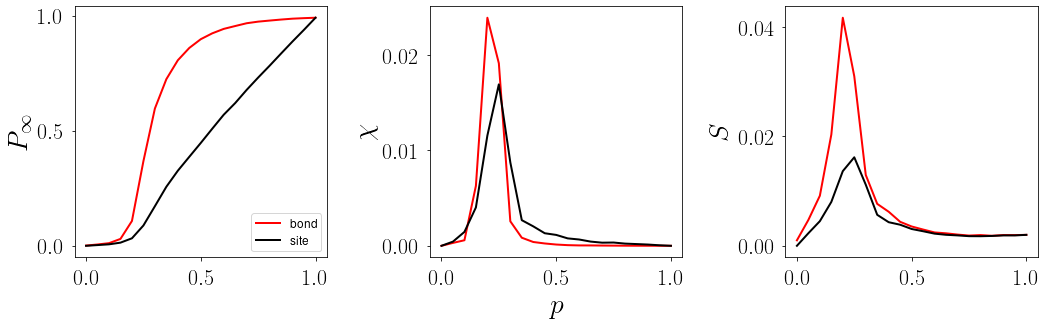

In [8]:
def add_to_plot (x_val, y_val, col, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(x_val)):
        x.append(x_val[i])
        y.append(y_val[i][col])
        
    
    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(15,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,3,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,3,2)
ax2.set_ylabel('$\\chi$', fontsize=28)
ax3 = fig.add_subplot(1,3,3)
ax3.set_ylabel('$S$', fontsize=28)


ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (p_vec, bond_perc, 0, ax1, 'red', 'bond')
add_to_plot (p_vec, site_perc, 0, ax1, 'black', 'site')


add_to_plot (p_vec, bond_perc, 1, ax2, 'red', 'bond')
add_to_plot (p_vec, site_perc, 1, ax2, 'black', 'site')


add_to_plot (p_vec, bond_perc, 2, ax3, 'red', 'bond')
add_to_plot (p_vec, site_perc, 2, ax3, 'black', 'site')






ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)
ax3.locator_params(nbins=4)



fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

# Newman-Ziff algorithm

The following code implements the Newman-Ziff (NZ) algorithm for ordinary percolation models. The NZ algorithm allows to draw the entire percolation diagram more efficiently than the naive implementations provided above. The ZN algorithm (or variants of the NZ algorithm) is used very often in percolation models on networks.

For more details on the NZ algorithm, see the original paper

M.E.J. Newman and R.M Ziff, 
[Efficient Monte Carlo Algorithm and High-Precision Results for Percolation](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.85.4104), 
Phys. Rev. Lett. 85, 4104 (2000)


Our implementation relies on three main functions: 1) One function takes care of (potential) mergers among clusters induced by the addition of single edges; 2) One function regulates what edges are sequentially added (site- and bond-percolation models differ in this respect); 3) One function repeats $T$ independent times the NZ algorithm.

In [10]:
def newman_ziff_find_root (n, root):
    if root[n][0] == n:
        return root[n]
    return newman_ziff_find_root (root[n][0], root)


def newman_ziff_merge_clusters (n, m, root):

    rn, sn = newman_ziff_find_root (n, root)
    rm, sm = newman_ziff_find_root (m, root)

    if rn != rm:
    
        if sn > sm:
            root[rm] = [rn, 1]
            root[rn] = [rn, sn+sm]
            return root[rn]
    
        root[rn] = [rm, 1]
        root[rm] = [rm, sn+sm]
        return root[rm]

    return root[rn]




def newman_ziff_bond_percolation (G, res_av, res_susc):
    
    N = float(len(G))
    
    list_of_edges = []
    for e in G.edges():
        list_of_edges.append([e[0], e[1]])
    random.shuffle(list_of_edges)
    
    root = {}
    for n in G:
        root[n] = [n, 1]
        
    P_infty = 1
    for i in range(0, len(list_of_edges)):
            n = list_of_edges[i][0]
            m = list_of_edges[i][1]
            q, P = newman_ziff_merge_clusters (n, m, root)
            if P > P_infty:
                P_infty = P
            res_av[i] += P_infty / N
            res_susc[i] += (P_infty / N) * (P_infty / N)
            
            
def newman_ziff_site_percolation (G, res_av, res_susc):
    
    N = float(len(G))
    
    list_of_nodes = list(G.nodes())
    random.shuffle(list_of_nodes)
    present = {}
    for n in list_of_nodes:
        present[n] = 0
        
    root = {}
    P_infty = 1
    
    for i in range(0, len(list_of_nodes)):
        n = list_of_nodes[i]
        present[n] = 1
        root[n] = [n, 1]
        for m in G.neighbors(n):
            if present[m] > 0:
                q, P = newman_ziff_merge_clusters (n, m, root)
                if P > P_infty:
                    P_infty = P
        res_av[i] += P_infty / N
        res_susc[i] += (P_infty / N) * (P_infty / N)
            
    
def multiple_newman_ziff_percolation (G, T, model):
    
    if model == 'bond':
        res_av = np.zeros(G.number_of_edges())
        res_susc = np.zeros(G.number_of_edges())
        for t in range(0, T):
            newman_ziff_bond_percolation (G, res_av, res_susc)
        for i in range(0, len(res_av)):
            res_av[i] /= float(T)
            res_susc[i] /= float(T)
            res_susc[i] -= res_av[i] * res_av[i]
            if res_av[i] >0.0:
                res_susc[i] /= res_av[i]
                
    if model == 'site':
        res_av = np.zeros(G.number_of_nodes())
        res_susc = np.zeros(G.number_of_nodes())
        for t in range(0, T):
            newman_ziff_site_percolation (G, res_av, res_susc)
        for i in range(0, len(res_av)):
            res_av[i] /= float(T)
            res_susc[i] /= float(T)
            res_susc[i] -= res_av[i] * res_av[i]
            if res_av[i] >0.0:
                res_susc[i] /= res_av[i]
                
                
                
    return res_av, res_susc     

In [11]:
## Simulations for bond percolation
res_av_bond, res_susc_bond = multiple_newman_ziff_percolation (G, T, 'bond')


In [12]:
## Simulations for site percolation
res_av_site, res_susc_site = multiple_newman_ziff_percolation (G, T, 'site')

## Visualize the results 

The code below serves only to visualize the behavior of the various observable as a function $p$.

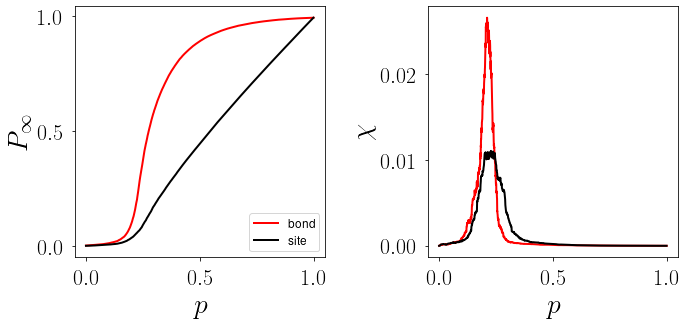

In [14]:
def add_to_plot (val, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(val)):
        x.append(float(i)/float(len(val)))
        y.append(val[i])
        
    
    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (res_av_bond, ax1, 'red', 'bond')
add_to_plot (res_av_site, ax1, 'black', 'site')


add_to_plot (res_susc_bond, ax2, 'red', 'bond')
add_to_plot (res_susc_site, ax2, 'black', 'site')







ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
fig.savefig('fig1.pdf')
plt.show()

## From the microcanonical to the canonical ensemble

The functions reported above provides numerical estimates of observables for a given number of occupied sites or bonds. In order to produce results that are actually equivalenet to ordinary percolation models, we need to estimate the values of the observables as a functions of the occupation probability $p$. The function below is devoted to it.

In [15]:
def nz_micro_to_canonical (res_av_micro, res_susc_micro, dp):
    
    threshold = 1.0e-6
    
    N = len(res_av_micro)
    
    p_vec = np.arange(0.0, 1.0+dp, dp)

    res_av_can = []
    res_susc_can = []
    
    
    for i in range(0, len(p_vec)):
        
        tmp_av = 0.0
        tmp_susc = 0.0
        norm = 0.0
        
        
        p = p_vec[i]
        
        n_c = int(float(N) * p) -1
        tmp = binom.pmf(n_c, N, p)
        tmp_av += tmp * res_av_micro[n_c]
        tmp_susc += tmp * res_susc_micro[n_c]
        norm += tmp
        
        for j in range(n_c+1, N):
            tmp = binom.pmf(j, N, p)
            if tmp > threshold:
                tmp_av += tmp * res_av_micro[j]
                tmp_susc += tmp * res_susc_micro[j]
                norm += tmp
            else:
                j = N
                
        for j in range(n_c-1, 0, -1):
            tmp = binom.pmf(j, N, p)
            if tmp > threshold:
                tmp_av += tmp * res_av_micro[j]
                tmp_susc += tmp * res_susc_micro[j]
                norm += tmp
            else:
                j = 0
                
                
        res_av_can.append(tmp_av/norm)
        res_susc_can.append(tmp_susc/norm)
        
        
    return p_vec, res_av_can, res_susc_can

In [16]:
bond_p_vec, bond_av_can, bond_susc_can = nz_micro_to_canonical (res_av_bond, res_susc_bond, 0.01)

In [17]:
site_p_vec, site_av_can, site_susc_can = nz_micro_to_canonical (res_av_site, res_susc_site, 0.01)

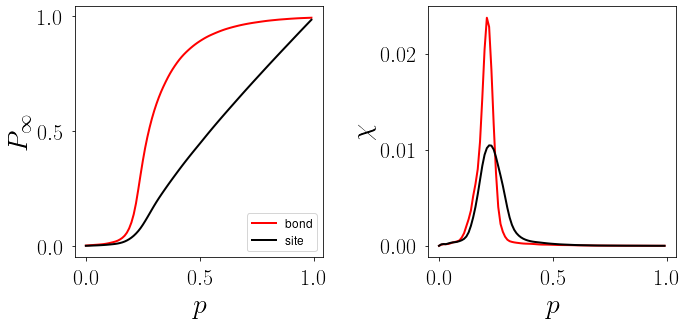

In [18]:
def add_to_plot (x, y, ax, color, label):
        
    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (bond_p_vec, bond_av_can, ax1, 'red', 'bond')
add_to_plot (site_p_vec, site_av_can, ax1, 'black', 'site')


add_to_plot (bond_p_vec, bond_susc_can, ax2, 'red', 'bond')
add_to_plot (site_p_vec, site_susc_can, ax2, 'black', 'site')







ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()


## Message-passing equations for the ordinary percolation models

The code makes use of the belief-propagation algorithm originally proposed by

Brian Karrer, M. E. J. Newman, and Lenka Zdeborová, 
[Percolation on Sparse Networks](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.208702), 
Phys. Rev. Lett. 113, 208702 (2014)

Kathleen E. Hamilton, and Leonid P. Pryadko, [Tight Lower Bound for Percolation Threshold on an Infinite Graph](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.113.208701), Phys. Rev. Lett. 113, 208701 (2014)

The code below takes as inputs a graph $G$ and the value of the site/bond occupation probability $p$. 

In [19]:
################################################################################## 
def percolation_message_passing_single_iteration (G, p, prob_edges, tmp_prob_edges):
    
    max_err = 0.0
    
      
    for e in tmp_prob_edges:
        tmp_prob_edges[e] = prob_edges[e]
                
        
    for e in prob_edges:
        n = e[0]
        m = e[1]
        
        prob_edges[e] = 1.0
        neigh = G.neighbors(m)
        for q in neigh:
            if q != n:
                prob_edges[e] = prob_edges[e] * (1.0 - p * tmp_prob_edges[m , q])
        prob_edges[e] = 1.0 - prob_edges[e]
        err = abs(prob_edges[e] - tmp_prob_edges[e])
        if err > max_err:
            max_err = err
            
    
    return max_err
################################################################################## 


def percolation_solve_message_passing_equations (G, p, prob_edges):
   
    tmp_prob_edges = {}
   
    for e in prob_edges:
        prob_edges[e] = random.random()
        tmp_prob_edges[e] = prob_edges[e]
             
    iteration = 0
    err = 1.0
    while err > 1e-6:
        err = percolation_message_passing_single_iteration (G, p, prob_edges, tmp_prob_edges)
        iteration += 1
    
        
################################################################################## 

def percolation_compute_percolation_strength (G, p):
    
    
    
    prob_edges = {}
    prob_nodes = {}
    for e in G.edges():
        prob_edges[e[0], e[1]] = 1.0
        prob_edges[e[1], e[0]] = 1.0
        
    for n in G:
        prob_nodes[n] = 1.0
    
    percolation_solve_message_passing_equations (G, p, prob_edges)

    for e in prob_edges:
        n = e[0]
        prob_nodes[n] = prob_nodes[n] * (1.0 - p * prob_edges[e])
        
    for n in G:  
        prob_nodes[n] = 1.0 - prob_nodes[n]
    
    
    perc_str = 0.0
    for n in G:
        perc_str += prob_nodes[n]
        
    perc_str /= float(len(G))
    

    
    
        
    return perc_str    
        
################################################################################## 
################################################################################## 
################################################################################## 


def non_backtracking_matrix_largest_eigenpair (G):
    
    M = nx.DiGraph()
    
    
    for e in G.edges():
        
        n = e[0]
        m = e[1]
        
        neigh = G.neighbors(m)
        for q in neigh:
            if q != n:
                M.add_edge((n,m), (m,q))
                
        neigh = G.neighbors(n)
        for q in neigh:
            if q != m:
                M.add_edge((m,n), (n,q))
                
    
    
    eig_vec = {}
    for r in M:
        eig_vec[r] = 1.0
        
        
    err = 1.0
    while err > 1.0e-6:
        norm, err = single_iteration_eig (M, eig_vec)
        
        
    return norm, eig_vec
        
        
        

def single_iteration_eig (M, eig_vec):
    
    tmp = eig_vec.copy()
    for r in eig_vec:
        eig_vec[r] = 0.0
        for q in M.predecessors(r):
            eig_vec[r] += tmp[q]
    
    norm = 0.0
    for r in eig_vec:
        norm += eig_vec[r]*eig_vec[r]
    norm = np.sqrt(norm)
    for r in eig_vec:
        eig_vec[r] /= norm
        
    err = 0.0
    for r in eig_vec:
        if abs(eig_vec[r]-tmp[r]) > err:
            err = abs(eig_vec[r]-tmp[r])
            
    return norm, err
    
    

In [20]:
mp_bond = []
for i in range(0, len(bond_p_vec)):
    p = bond_p_vec[i]
    mp_bond.append(percolation_compute_percolation_strength(G, p)) 

In [21]:
mu, eig = non_backtracking_matrix_largest_eigenpair (G)
print ('Largest eigenvalue non-backtracking matrix : ', mu)
print ('Predicted percolation threshold : ', 1.0/mu)

Largest eigenvalue non-backtracking matrix :  5.070809403788205
Predicted percolation threshold :  0.19720717549607342


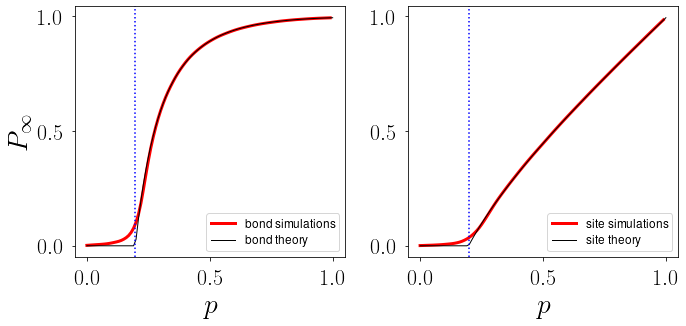

In [22]:
def add_to_plot (x, y, ax, lw, color,label):
        
    ax.plot(x, y, linestyle='-', linewidth=lw, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)



ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (bond_p_vec, bond_av_can, ax1, 3.0, 'red', 'bond simulations')
add_to_plot (bond_p_vec, mp_bond, ax1, 1.0, 'black', 'bond theory')


mp_site = []
for i in range(0, len(bond_p_vec)):
    p = bond_p_vec[i]
    mp_site.append(mp_bond[i]*p)



add_to_plot (bond_p_vec, site_av_can, ax2, 3.0, 'red', 'site simulations')
add_to_plot (bond_p_vec, mp_site, ax2, 1.0, 'black', 'site theory')



ax1.axvline(x=1.0/mu, color='blue', linewidth=1.5, linestyle='dotted')
ax2.axvline(x=1.0/mu, color='blue', linewidth=1.5, linestyle='dotted')



ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax2.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

## Explosive percolation

A minimal modification of the Newman-Ziff algorithm is used in the "explosive" percolation model. For more details see

D. Achlioptas, R. M. D'Souza, J. Spencer, 
[Explosive Percolation in Random Networks](http://science.sciencemag.org/content/323/5920/1453), 
Science 323, 1453-1455 (2009)

F. Radicchi and S. Fortunato, 
[Explosive Percolation in Scale-Free Networks](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.168701), 
Phys. Rev. Lett. 103, 168701 (2010)

In [43]:
def test_merger (n, m, root):
    rn, sn = newman_ziff_find_root (n, root)
    rm, sm = newman_ziff_find_root (m, root)
    return sn*sm


   


def explosive_percolation (G, res_av, res_susc):
    
    N = float(len(G))
    
    list_of_edges = []
    for e in G.edges():
        list_of_edges.append([e[0], e[1]])
    
    root = {}
    for n in G:
        root[n] = [n, 1]
    
        
    P_infty = 1
    i = 0
    while len(list_of_edges) >= 2:
        
        e1 = random.randint(0, len(list_of_edges)-1)
        e2 = e1
        while e2 == e1:
            e2 = random.randint(0, len(list_of_edges)-1)
        
        ##test 1
        n = list_of_edges[e1][0]
        m = list_of_edges[e1][1]
        s1 = test_merger (n, m, root)
        
        ##test 1
        n = list_of_edges[e2][0]
        m = list_of_edges[e2][1]
        s2 = test_merger (n, m, root)
        
        
        if s1 < s2:
            n = list_of_edges[e1][0]
            m = list_of_edges[e1][1]
            list_of_edges[e1][0] = list_of_edges[len(list_of_edges)-1][0]
            list_of_edges[e1][1] = list_of_edges[len(list_of_edges)-1][1]
        else:
            n = list_of_edges[e2][0]
            m = list_of_edges[e2][1]
            list_of_edges[e2][0] = list_of_edges[len(list_of_edges)-1][0]
            list_of_edges[e2][1] = list_of_edges[len(list_of_edges)-1][1]
            
        del list_of_edges[-1]
        
    
            
   
        q, P = newman_ziff_merge_clusters (n, m, root)
        i = i + 1
    
        if P > P_infty:
            P_infty = P
        res_av[i] += P_infty / N
        res_susc[i] += (P_infty / N) * (P_infty / N)
            
            
def multiple_explosive_percolation (G, T):
    
    
    res_av = np.zeros(G.number_of_edges())
    res_susc = np.zeros(G.number_of_edges())
    for t in range(0, T):
        explosive_percolation (G, res_av, res_susc)
    for i in range(0, len(res_av)):
        res_av[i] /= float(T)
        res_susc[i] /= float(T)
        res_susc[i] -= res_av[i] * res_av[i]
        if res_av[i] >0.0:
            res_susc[i] /= res_av[i]
                
    
                
                
    return res_av, res_susc     

In [44]:
## Simulations for bond percolation
explosive_av, explosive_susc = multiple_explosive_percolation (G, T)

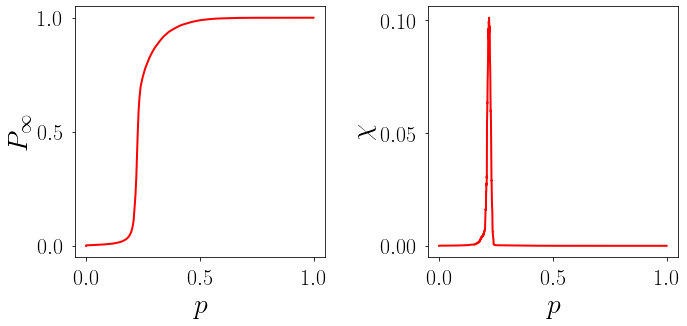

In [45]:
def add_to_plot (val, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(val)-2):
        x.append(float(i)/float(len(val)))
        y.append(val[i])
        
    
    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)






add_to_plot (explosive_av, ax1, 'red', '')


add_to_plot (explosive_susc, ax2, 'red', '')







#ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)


fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

## Optimal percolation

Numerical implementation of the model introduced in

Flaviano Morone and Hernán A. Makse, 
[Influence maximization in complex networks through optimal percolation](https://www.nature.com/articles/nature14604), 
Nature 524, pages 65–68 (2015).

The code below remove nodes from a graph based on the value of collective influence. The algorithm to compute collective influence is not optimized. For a more efficient implementation see the paper

Flaviano Morone, Byungjoon Min, Lin Bo, Romain Mari and Hernán A. Makse, 
[Collective Influence Algorithm to find influencers via optimal percolation in massively large social media](https://www.nature.com/articles/srep30062), 
Scientific Reports 6, 30062 (2016).

In [23]:
def bfs_ball (G, n, ell):
    
    visited = {}
    queue = []
    
    queue.append(n)
    visited[n] = 0
    d = 0
    
    while len(queue)>0 and d < ell:
        tmp_queue = []
        d += 1
        for i in queue:
            for j in G.neighbors(i):
                if j not in visited:
                    visited[j] = d
                    tmp_queue.append(j)
        queue = []
        for i in tmp_queue:
            queue.append(i)

    return queue, visited


def compute_collective_influence (G, n, ell):
    
    tmp = G.degree(n)-1
    if ell > 0: 
        tmp = 0.0
        queue, visited = bfs_ball (G, n, ell)
        for j in queue:
            tmp += G.degree(j)-1
        tmp *= G.degree(n)-1
            
    return tmp
    


def remove_max_collective_influence (G, ell, state):
    
    max_ci = -1.0
    top_ci = []
    for n in G:
        if state[n] > 0:
            ci = compute_collective_influence (G, n, ell)
            if max_ci < 0 or ci > max_ci:
                max_ci = ci
                top_ci = []
            if max_ci == ci:
                top_ci.append(n)
            
            
    return max_ci, top_ci
        

def collective_influence_dismantle_network (G, ell):
    
    list_of_nodes = []
    
    ## copy the graph
    H = G.copy()
    
    N = len(H)
    state = {}
    for n in H:
        state[n] = 1
    
    
    ## dismantle the graph
    while N > 0:
        max_ci, top_ci = remove_max_collective_influence (H, ell, state)
        n = random.choice(top_ci)
        H.remove_node(n)
        state[n] = -1
        N -= 1
        list_of_nodes.append(n)
        
    list_of_nodes.reverse()
        
    return list_of_nodes

#################


def newman_ziff_optimal_percolation (G, ell):
    
    
    N = float(len(G))
    
    list_of_nodes = collective_influence_dismantle_network (G, ell)
    
    av = np.zeros(len(list_of_nodes))

    present = {}
    for n in list_of_nodes:
        present[n] = 0
        
    root = {}
    P_infty = 1
    
    for i in range(0, len(list_of_nodes)):
        n = list_of_nodes[i]
        present[n] = 1
        root[n] = [n, 1]
        for m in G.neighbors(n):
            if present[m] > 0:
                q, P = newman_ziff_merge_clusters (n, m, root)
                if P > P_infty:
                    P_infty = P
        av[i] = P_infty / N
    

    return av

In [24]:
ell = 0
av = newman_ziff_optimal_percolation (G, ell)

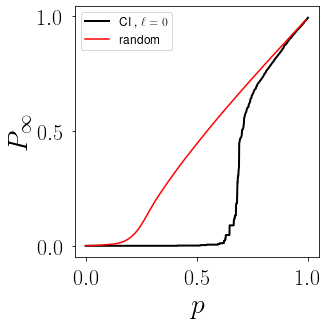

In [25]:
def add_to_plot (val, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(val)):
        x.append(float(i)/float(len(val)))
        y.append(val[i])
        
    ax.plot(x, y, linestyle='-', linewidth=2, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(5,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax1.set_xlabel('$p$', fontsize=28)






add_to_plot (av, ax1, 'black', 'CI , $\\ell = %d$' % ell)
ax1.plot(bond_p_vec, site_av_can, color = 'red', label = 'random')








ax1.legend(loc=2, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)



fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

## Percolation in interdependent networks

Numerical implementation of the model introduced in
Sergey V. Buldyrev et al., 
[Catastrophic cascade of failures in interdependent networks](http://www.nature.com/nature/journal/v464/n7291/abs/nature08932.html), 
Nature 464, 1025-1028 (2010)

In [26]:
def percolation_interdependent_networks (G1, G2, p):
    
    present = {}
    
    H1 = G1.copy()
    H2 = G2.copy()
    
    
    for n in G1:
        present[n] = 1
        if random.random() <= 1.0 -p:
            H1.remove_node(n)
            present[n] = 0
    
      
        
    var = 1
    iteration = 0
    while var > 0:
        
        iteration += 1
        
        Hc1 = {}
        if len(H1) > 0:
            Hc1 = max(nx.connected_components(H1), key=len)
        Hc2 = {}
        if len(H2) > 0:
            Hc2 = max(nx.connected_components(H2), key=len)
        
        var = 0
        for n in G1:
            if n not in Hc1 or n not in Hc2:
                if present[n] == 1:
                    var += 1
                present[n] = 0
           
                
        for n in present:
            if present[n] == 0:
                if n in H1:
                    H1.remove_node(n)
                if n in H2:
                    H2.remove_node(n)
                    
    #print (p, iteration)
                    
                    
    if len(H1) == 0 or len(H2) == 0:
        return 0.0
    return float(len(max(nx.connected_components(H1), key=len))) / float(len(G1))


#############################




def multiple_realizations_percolation_interdependent_networks (G1, G2, p, T):
    
    
        
    
    av = 0.0
    susc = 0.0
   
   
    
    t = 0
    while t < T:
        
       
        P_infty = percolation_interdependent_networks (G1, G2, p)
        
        av += P_infty
        susc += P_infty * P_infty
        
        
        t += 1
        
    av /= T
    susc /= T
    susc -= av * av
    if av >0.0:
        susc /= av

    
    return av, susc
        

In [27]:
N = 1000
k = 7.0
G1 = nx.erdos_renyi_graph(N, k / float(N-1))
G2 = nx.erdos_renyi_graph(N, k / float(N-1))

##this loop serves to include in the graph also nodes with degree equal to zero
for n in range(0, N):
    G1.add_node(n)
    G2.add_node(n)
    
    


In [28]:
T = 100
dp = 0.1
interdependent_p_vec = np.arange(0.0, 1.0+dp, dp)

interdependent_perc = []


for i in range (0, len(interdependent_p_vec)):
    p = interdependent_p_vec[i]
    print (p)
    interdependent_perc.append(multiple_realizations_percolation_interdependent_networks (G1, G2, p, T))
    

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


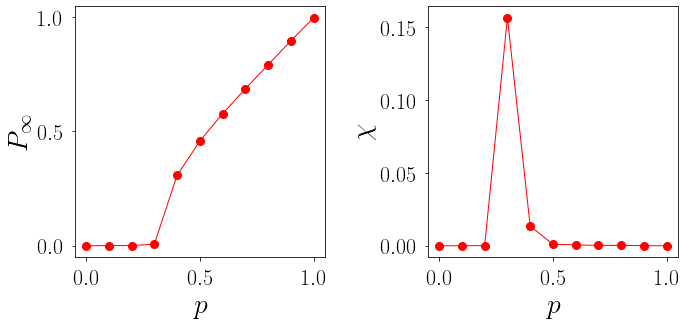

In [29]:
def add_to_plot (x_val, y_val, col, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(x_val)):
        x.append(x_val[i])
        y.append(y_val[i][col])
        
    
    ax.plot(x, y, marker = 'o', markersize = 8.0, linestyle='-', linewidth=1, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('$\\chi$', fontsize=28)


ax1.set_xlabel('$p$', fontsize=28)
ax2.set_xlabel('$p$', fontsize=28)





add_to_plot (interdependent_p_vec, interdependent_perc, 0, ax1, 'red', '')

add_to_plot (interdependent_p_vec, interdependent_perc, 1, ax2, 'red', '')






#ax1.legend(loc=4, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)
ax2.locator_params(nbins=4)
#ax3.locator_params(nbins=4)



fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()

## Message-passing equations for percolation on interdependent networks

The code makes use of the algorithm originally proposed by

Filippo Radicchi, 
[Percolation in real interdependent networks](http://www.nature.com/nphys/journal/v11/n7/full/nphys3374.html), 
Nature Phys. 11, 597–602 (2015)

In [30]:
def find_intersection_and_remainders (G1, G2):
    
    Intersection = nx.Graph()
    OnlyG1 = nx.Graph()
    OnlyG2 = nx.Graph()
    
    for n in G1:
        Intersection.add_node(n)
        OnlyG1.add_node(n)
        OnlyG2.add_node(n)
        
    
    for e in G1.edges():
        if G2.has_edge(e[0], e[1]):
            Intersection.add_edge(e[0], e[1])
        else:
            OnlyG1.add_edge(e[0], e[1])
            
    for e in G2.edges():
        if G1.has_edge(e[0], e[1]):
            ##add the same edge twice
            Intersection.add_edge(e[0], e[1])
        else:
            OnlyG2.add_edge(e[0], e[1])
        
    
    return Intersection, OnlyG1, OnlyG2
    

################################################################################## 

def interdependent_percolation_message_passing_single_iteration (Intersection, OnlyG1, OnlyG2, p, prob_edges, tmp_prob_edges):
    
    max_err = 0.0
    
      
    for e in tmp_prob_edges:
        tmp_prob_edges[e] = prob_edges[e]
        
        
    for e in prob_edges:
        
        n = e[0]
        m = e[1]
        tmp_int = 1.0
        tmp_1 = 1.0
        tmp_2 = 1.0
                
        
        neigh = Intersection.neighbors(m)
        for q in neigh:
            if q != n:
                tmp_int = tmp_int * (1.0 - tmp_prob_edges[m , q])
        tmp_int = 1.0 - tmp_int
        
        
        neigh = OnlyG1.neighbors(m)
        for q in neigh:
            if q != n:
                tmp_1 = tmp_1 * (1.0 - tmp_prob_edges[m , q])
        tmp_1 = 1.0 - tmp_1
        
        neigh = OnlyG2.neighbors(m)
        for q in neigh:
            if q != n:
                tmp_2 = tmp_2 * (1.0 - tmp_prob_edges[m , q])
        tmp_2 = 1.0 - tmp_2
        
                
                
                
        prob_edges[e] = p * (tmp_int + (1.0 - tmp_int) * tmp_1 * tmp_2)
        err = abs(prob_edges[e] - tmp_prob_edges[e])
        if err > max_err:
            max_err = err
            
    
    return max_err
################################################################################## 


def interdependent_percolation_solve_message_passing_equations (Intersection, OnlyG1, OnlyG2, p, prob_edges):
   
    tmp_prob_edges = {}
   
    for e in prob_edges: 
        prob_edges[e] = random.random()
        tmp_prob_edges[e] = prob_edges[e]
             
    iteration = 0
    err = 1.0
    while err > 1e-6:
        err = interdependent_percolation_message_passing_single_iteration (Intersection, OnlyG1, OnlyG2, p, prob_edges, tmp_prob_edges)
        iteration += 1
        
    return iteration
    
        
################################################################################## 

def interdependent_percolation_compute_percolation_strength(G1, G2, p):
    
    Intersection, OnlyG1, OnlyG2 = find_intersection_and_remainders (G1, G2)
    
    
    prob_edges = {}
    prob_nodes = {}
    
    for e in Intersection.edges():
        prob_edges[e[0], e[1]] = 1.0
        prob_edges[e[1], e[0]] = 1.0
        
    for e in OnlyG1.edges():
        prob_edges[e[0], e[1]] = 1.0
        prob_edges[e[1], e[0]] = 1.0
        
    for e in OnlyG2.edges():
        prob_edges[e[0], e[1]] = 1.0
        prob_edges[e[1], e[0]] = 1.0
        
        
        
    
    iteration = interdependent_percolation_solve_message_passing_equations (Intersection, OnlyG1, OnlyG2, p, prob_edges)
    
    
    
    
    
    
    for e in prob_edges:
        n = e[0]
        tmp_int = 1.0
        tmp_1 = 1.0
        tmp_2 = 1.0
                
        
        neigh = Intersection.neighbors(n)
        for q in neigh:
            tmp_int = tmp_int * (1.0 - prob_edges[n , q])
        tmp_int = 1.0 - tmp_int
        
        neigh = OnlyG1.neighbors(n)
        for q in neigh:
            tmp_1 = tmp_1 * (1.0 - prob_edges[n , q])
        tmp_1 = 1.0 - tmp_1
        
        neigh = OnlyG2.neighbors(n)
        for q in neigh:
            tmp_2 = tmp_2 * (1.0 - prob_edges[n , q])
        tmp_2 = 1.0 - tmp_2
        
        
        prob_nodes[n] = p * (tmp_int + (1.0 - tmp_int) * tmp_1 * tmp_2)
    
    
    perc_str = 0.0
    for n in G1:
        perc_str += prob_nodes[n]
        
    perc_str /= float(len(G1))
    

    
    
        
    return perc_str, iteration    
        
################################################################################## 
################################################################################## 
################################################################################## 

In [31]:
mp_interdependent = []
mp_interdependent_iteration = []
dp = 0.01
mp_interdependent_p_vec = np.arange(0.0, 1.0+dp, dp)

for i in range(0, len(mp_interdependent_p_vec)):
    p = mp_interdependent_p_vec[i]
    val, iteration = interdependent_percolation_compute_percolation_strength(G1, G2, p)
    #print (p, val, iteration)
    mp_interdependent.append(val) 
    mp_interdependent_iteration.append(iteration) 

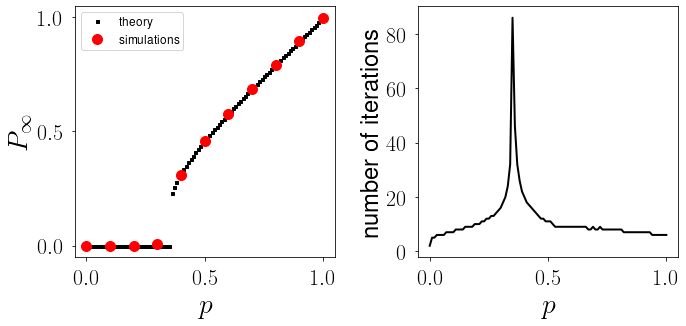

In [32]:
def add_to_plot (x_val, y_val, col, ax, color, label):
    
    x = []
    y = []
    
    for i in range (0, len(x_val)):
        x.append(x_val[i])
        y.append(y_val[i][col])
        
    
    ax.plot(x, y, marker = 'o', markersize = 10.0, linestyle='-', linewidth=0, color=color, label=label)





fig = plt.figure()
fig.set_size_inches(10,5)
plt.rc('text', usetex=True)
plt.rc('font', size=22, **{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



ax1 = fig.add_subplot(1,2,1)
ax1.set_ylabel('$P_\infty$', fontsize=28)
ax1.set_xlabel('$p$', fontsize=28)


ax2 = fig.add_subplot(1,2,2)
ax2.set_ylabel('number of iterations', fontsize=24)
ax2.set_xlabel('$p$', fontsize=28)







ax1.plot(mp_interdependent_p_vec, mp_interdependent, color = 'k', linewidth=0, marker='s', markersize = 3, label= 'theory')
add_to_plot (interdependent_p_vec, interdependent_perc, 0, ax1, 'red', 'simulations')


ax2.plot(mp_interdependent_p_vec, mp_interdependent_iteration, color = 'k', linewidth=2, marker='s', markersize = 0, label= 'theory')



ax1.legend(loc=2, numpoints=1, prop={'size':12})
ax1.locator_params(nbins=4)



fig.tight_layout()
#fig.savefig('fig1.pdf')
plt.show()